In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import statsmodels.api as sm
import scipy.optimize as scopt
import os
%matplotlib inline

c:\users\evergreen\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#load data
stocks = pd.read_csv(os.path.join('data2','sp500_closes-12.10.2017.csv'),index_col=0)
stock_list = stocks.columns.tolist()
print("^GSPC and stocks:\n",stock_list)
#print(stocks.head())
print("Stocks shape:",stocks.shape)
#print(stocks.describe())

^GSPC and stocks:
 ['MMM', 'ABT', 'ABBV', 'ACN', 'ATVI', 'AYI', 'ADBE', 'AMD', 'AAP', 'AES', 'AET', 'AMG', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN', 'ALGN', 'ALLE', 'AGN', 'ADS', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'APC', 'ADI', 'ANDV', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'AIV', 'AAPL', 'AMAT', 'ADM', 'ARNC', 'AJG', 'AIZ', 'T', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BHGE', 'BLL', 'BAC', 'BK', 'BCR', 'BAX', 'BBT', 'BDX', 'BRK.B', 'BBY', 'BIIB', 'BLK', 'HRB', 'BA', 'BWA', 'BXP', 'BSX', 'BHF', 'BMY', 'AVGO', 'BF.B', 'CHRW', 'CA', 'COG', 'CDNS', 'CPB', 'COF', 'CAH', 'CBOE', 'KMX', 'CCL', 'CAT', 'CBG', 'CBS', 'CELG', 'CNC', 'CNP', 'CTL', 'CERN', 'CF', 'SCHW', 'CHTR', 'CHK', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'XEC', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'CXO', 'COP', 'ED', 'STZ', 'COO', 'GLW', 'COST', 'COTY', 'CCI', 'CS

In [3]:
#load distance
distances = pd.read_csv(os.path.join('data2','pca500-distance.csv'),index_col=0)
selected_stock_list = distances.index.tolist()
print("Selected and favoraite stocks:\n",selected_stock_list)

print("Distance shape:",distances.shape)
print("Distance head:\n",distances.head())
#print(stocks.describe())
num_stocks = len(selected_stock_list)

Selected and favoraite stocks:
 ['EXC', 'NEM', 'HPQ', 'APA', 'CHK', 'C', 'AMD', 'MOS', 'DVN', 'AIG', 'BBY', 'BAC', 'NFX', 'ARNC', 'NVDA', 'DXC', 'EA', 'ETFC', 'FCX', 'BSX', 'FE', 'VMC', 'ATVI', 'LUK', 'MS', 'MGM', 'GPN', 'CME', 'AMAT', 'M']
Distance shape: (30, 6)
Distance head:
          PCA1      PCA2      PCA3      PCA4      PCA5  Distance
EXC -0.217881 -0.550922  0.682555  0.114160 -0.064291  1.490365
NEM -0.552846 -0.167523 -0.012832 -0.602370 -0.381328  1.464097
HPQ  0.034811 -0.594821  0.444281 -0.097389 -0.035268  1.396314
APA -0.639347  0.259524  0.531898 -0.323917 -0.263473  1.356892
CHK -0.589443  0.245435  0.717297 -0.027842 -0.046916  1.313544


In [4]:
#get selected stocks data
data = stocks[selected_stock_list]
print("Data shape: ", data.shape)
print("Data describe():\n", data.describe())

Data shape:  (2519, 30)
Data describe():
                EXC          NEM          HPQ          APA          CHK  \
count  2519.000000  2519.000000  2519.000000  2519.000000  2519.000000   
mean     33.292316    37.252519    13.564704    76.265895    19.000859   
std       7.391183    11.515784     3.662053    21.038075    10.121561   
min      23.102039    15.395187     4.542605    33.111366     1.590000   
25%      29.754498    26.498153    10.855866    59.535692    13.057154   
50%      31.644169    37.557098    13.715755    77.677505    19.227114   
75%      34.464806    45.635046    16.480111    90.953167    24.309543   
max      61.234791    65.662872    22.120001   131.638153    59.329266   

                 C          AMD          MOS          DVN          AIG  \
count  2519.000000  2519.000000  2519.000000  2519.000000  2519.000000   
mean     61.777684     5.685058    45.881483    57.472423    93.460483   
std      55.065615     3.125815    18.661048    16.069033   180.03531

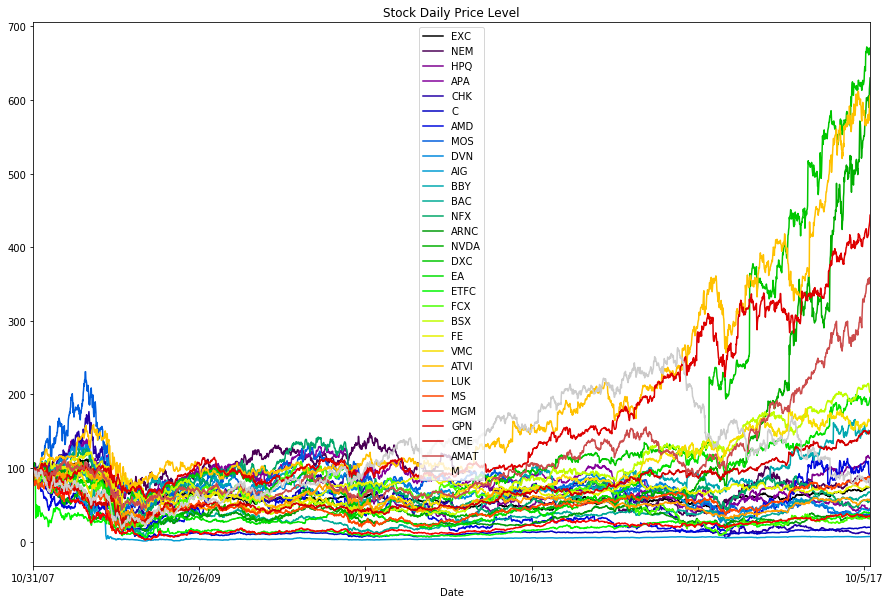

In [5]:
#normalize data to start with 100 level

ndata = (data / data.iloc[0] * 100)
ndata.plot(title="Stock Daily Price Level",cmap='nipy_spectral',figsize=(15, 10))


In [6]:
#we are going to use minimize function to optimize portfolio
def portfolio(weights):
    ''' Parameters 
    weights : array, weights for different stocks
    
    Returns
    p_return : float,  portfolio return
    p_volatility : float,  portfolio volatility
    p_return_to_risk : float, Sharpe ratio for rf=0
    '''
    weights = np.array(weights)
    p_return = np.sum(s_returns.mean() * weights) * 252
    p_volatility = np.sqrt(np.dot(weights.T, np.dot(s_returns.cov() * 252, weights)))
    p_return_to_risk = p_return/p_volatility
    return np.array([p_return, p_volatility, p_return_to_risk])

#Minimize loss
def objective(weights):
    return -portfolio(weights)[2]

#constrain,total normalized weights equal to 1
def constrain1(x):
    return ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

#weights are bound to be within 0 and 1.
bnds = tuple((0, 1) for x in range(num_stocks))



In [7]:
#we start with equal weights
weights = np.array(num_stocks * [1. / num_stocks,])
#returen
s_returns = np.log(data / data.shift(1))
# expected portfolio variance
p_volatility=np.dot(weights.T, np.dot(s_returns.cov() * 252, weights))
p_volatility


0.08733436293539068

In [8]:
%%time
p_returns = []
p_volatilities = []
for p in range (2500):
    weights = np.random.random(num_stocks)
    weights /= np.sum(weights)
    p_returns.append(np.sum(s_returns.mean() * weights) * 252)
    p_volatilities.append(np.sqrt(np.dot(weights.T,np.dot(s_returns.cov() * 252, weights))))
p_returns = np.array(p_returns)
p_volatilities = np.array(p_volatilities)

Wall time: 19.1 s


In [9]:
%%time
solution = scopt.minimize(objective, num_stocks * [1. / num_stocks,], method='SLSQP',bounds=bnds, constraints=cons)

Wall time: 1.71 s


In [10]:
solution

     fun: -0.6821253518961655
     jac: array([  4.34979834e-01,   3.63145426e-01,   4.07361083e-01,
         8.79509486e-01,   1.54678028e+00,   1.42672500e+00,
         7.82521389e-01,   1.00994129e+00,   8.75297002e-01,
         1.81253666e+00,   3.19718361e-01,   9.38653305e-01,
         8.81948650e-01,   1.15631635e+00,   4.54694033e-04,
        -1.42499804e-04,   3.32096845e-01,   1.19854996e+00,
         1.23994561e+00,   1.83263205e-01,   3.99022669e-01,
         3.55581746e-01,  -6.05806708e-05,   9.05580930e-01,
         9.41809669e-01,   1.15366627e+00,   1.01067126e-04,
         3.94015417e-01,   3.52906883e-02,   7.05755718e-01])
 message: 'Optimization terminated successfully.'
    nfev: 224
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([  1.52480222e-13,   1.53797125e-13,   2.37180702e-13,
         3.16000313e-13,   4.33485376e-13,   4.66409869e-13,
         4.29795150e-13,   3.76302222e-13,   3.13287986e-13,
         4.70035029e-13,   2.32180725e-13

In [11]:
#get stock weight with highest return
solution['x'].round(3)


array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.046,  0.265,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.327,  0.   ,
        0.   ,  0.   ,  0.362,  0.   ,  0.   ,  0.   ])

In [12]:
#get resturn, valitility, and sharpe ratio
portfolio(solution['x']).round(3)

array([ 0.172,  0.252,  0.682])

In [13]:
#minimize variance
def objective2(weights):
    return portfolio(weights)[1] ** 2

solution2 = scopt.minimize(objective2, num_stocks * [1. / num_stocks,], method='SLSQP', bounds=bnds,constraints=cons)

solution2['x'].round(3)

array([ 0.166,  0.087,  0.073,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.039,  0.   ,  0.   ,  0.   ,  0.   ,  0.03 ,
        0.   ,  0.   ,  0.   ,  0.035,  0.265,  0.   ,  0.072,  0.   ,
        0.   ,  0.   ,  0.204,  0.   ,  0.027,  0.   ])

In [14]:
#max portfolio return with target return
cons = ({'type': 'eq', 'fun': lambda x: portfolio(x)[0] - tret},{'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

#minimize valitility
def objective3(weights):
    return portfolio(weights)[1]

In [15]:
%%time
tgt_returns = np.linspace(0, 0.3, 50)
tgt_volatilities = []
for tgt_return in tgt_returns:
    cons = ({'type': 'eq', 'fun': lambda x: portfolio(x)[0] - tgt_return},{'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    res = scopt.minimize(objective3, num_stocks * [1. / num_stocks,], method='SLSQP',bounds=bnds, constraints=cons)
    tgt_volatilities.append(res['fun'])
tgt_volatilities = np.array(tgt_volatilities)


Wall time: 17min 21s


In [16]:
print("return: ",portfolio(solution['x'])[0])
print("volatility", portfolio(solution['x'])[1])
print (("sharpe ratio", portfolio(solution['x'])[2]))
print ("solution:\n", (solution['x']).round(3))

return:  0.171753328383
volatility 0.251791445525
('sharpe ratio', 0.68212535189616552)
solution:
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.046  0.265  0.     0.     0.     0.     0.     0.
  0.327  0.     0.     0.     0.362  0.     0.     0.   ]


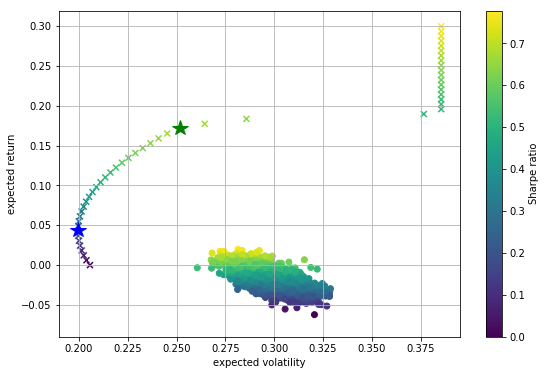

In [17]:
''' the dots----random portfolios; blue star (leftmost)--- minimum risk portfolio;  green star -- max return with min risk'''
plt.figure(figsize=(9, 6))

plt.scatter(p_volatilities, p_returns,c=p_returns/p_volatilities, marker='o')# random portfolio composition
plt.scatter(tgt_volatilities, tgt_returns,c=tgt_returns / tgt_volatilities, marker='x')# efficient frontier
plt.plot(portfolio(solution['x'])[1], portfolio(solution['x'])[0],'g*', markersize=16.0)# portfolio with highest Sharpe ratio
plt.plot(portfolio(solution2['x'])[1], portfolio(solution2['x'])[0],'b*', markersize=16.0)# minimum variance portfolio
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
